In [1]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
import matplotlib.pyplot as plt

# Functions

In [2]:
def compare_means(group1, group2, alpha=0.05):
    '''
    Compare means of two groups using t-test, Welch's t-test, or Mann-Whitney U test.
    The function checks normality and homoscedasticity assumptions before performing the corresponding test.

    Args:
    group1 (array-like): First group of data
    group2 (array-like): Second group of data

    Returns:
    dict: A dictionary containing the results of the test, including the test used, p-value, and conclusion.
    '''
    results = {}

    # Shapiro-Wilk test for normality
    shapiro_group1 = stats.shapiro(group1)
    shapiro_group2 = stats.shapiro(group2)

    # Levene's test for equal variances
    levene_test = stats.levene(group1, group2)

    # Check normality assumption
    normality_pass = (shapiro_group1.pvalue > alpha) and (shapiro_group2.pvalue > alpha)
    results['normality_pass'] = normality_pass

    # Check homoscedasticity assumption
    homoscedasticity_pass = levene_test.pvalue > alpha
    results['homoscedasticity_pass'] = homoscedasticity_pass

    if normality_pass:
        # Perform t-test (either standard or Welch's based on Levene's test result)
        if homoscedasticity_pass:
            # Equal variances assumed
            t_test = stats.ttest_ind(group1, group2, equal_var=True)
            results['test'] = "t-test"
        else:
            # Equal variances not assumed
            t_test = stats.ttest_ind(group1, group2, equal_var=False)
            results['test'] = "Welch's t-test"

        results['p_value'] = t_test.pvalue
    else:
        # Use Mann-Whitney U test if normality is not met
        mannwhitneyu_test = stats.mannwhitneyu(group1, group2)
        results['test'] = "Mann-Whitney U test"
        results['p_value'] = mannwhitneyu_test.pvalue

    # Conclusion based on p-value
    if results['p_value'] < alpha:
        results['conclusion'] = "reject, we can assume a difference"
    else:
        results['conclusion'] = "no reject, we can assume the means are equal"

    # Sample sizes
    results['n1'] = len(group1)
    results['n2'] = len(group2)

    return results

def compare_f1_scores_of_groups(df, group):
    # Calculate average F1 scores for each group
    avg_f1_scores = df.groupby(group)['test_f1'].mean()
    print("Average F1 scores:\n", avg_f1_scores)

    # Create a boxplot
    sns.boxplot(x=group, y='test_f1', data=df)
    plt.title('Boxplot of F1 Scores by ' + group)
    plt.ylabel('F1 Score')
    plt.show()


# Results for models with several runs

In [3]:
import os
import json
import pandas as pd
import numpy as np

def gather_metrics(base_dir):
    # List to hold raw metrics data
    raw_data = []

    # Traverse the base directory for models
    for model_dir in os.listdir(base_dir):
        model_path = os.path.join(base_dir, model_dir)

        if os.path.isdir(model_path):
            # Check subdirectories like run1, run2, ...
            for run_subdir in os.listdir(model_path):
                run_path = os.path.join(model_path, run_subdir)

                if os.path.isdir(run_path):
                    metrics_file = os.path.join(run_path, 'test_metrics.json')

                    if os.path.exists(metrics_file):
                        with open(metrics_file, 'r') as f:
                            metrics = json.load(f)

                        # Collect the metrics
                        f1 = (metrics.get('test_f1') or metrics.get('f1')) * 100
                        precision = (metrics.get('test_precision') or metrics.get('precision')) * 100
                        recall = (metrics.get('test_recall') or metrics.get('recall')) * 100
                        accuracy = (metrics.get('test_accuracy') or metrics.get('accuracy')) * 100

                        # Determine if 'context' is in the directory name
                        context = 'context' in model_dir.lower()
                        hashtags = 'hashtags' in model_dir.lower()
                        mentions = 'mentions' in model_dir.lower()
                        emojis = 'emojis' in model_dir.lower()
                        sentiment_scores = 'VADER' in model_dir or 'VAD' in model_dir
                        pos = 'POS' in model_dir
                        fc_after_features = 'fc_features' in model_dir
                        modified_class_head = 'modified_class_head' in model_dir
                        dropout_between_fc = 'dropout_between_fc' in model_dir

                        # Append raw data
                        raw_data.append({
                            'directory': model_dir,
                            'run': run_subdir,
                            'test_f1': f1,
                            'test_precision': precision,
                            'test_recall': recall,
                            'test_accuracy': accuracy,
                            'context': context,
                            'hashtags': hashtags,
                            'mentions': mentions,
                            'emojis': emojis,
                            'sentiment_scores': sentiment_scores,
                            'pos': pos,
                            'fc_after_features': fc_after_features,
                            'modified_class_head': modified_class_head,
                            'dropout_between_fc': dropout_between_fc
                        })

    # Create Raw DataFrame
    raw_df = pd.DataFrame(raw_data)

    # Group by 'directory' and calculate average and standard deviation
    summary_df = raw_df.groupby('directory').agg({
        'test_f1': ['mean', 'std'],
        'test_precision': 'mean',
        'test_recall': 'mean',
        'test_accuracy': 'mean',
        'context': 'first',
        'hashtags': 'first',
        'mentions': 'first',
        'emojis': 'first',
        'sentiment_scores': 'first',
        'pos': 'first',
        'fc_after_features': 'first',
        'modified_class_head': 'first',
        'dropout_between_fc': 'first'
    }).reset_index()

    # Rename columns
    summary_df.columns = ['_'.join(col).strip('_') for col in summary_df.columns.values]

    # Rename specific columns for clarity
    summary_df = summary_df.rename(columns={
        'test_f1_mean': 'test_f1',
        'test_f1_std': 'std_test_f1',
        'test_precision_mean': 'test_precision',
        'test_recall_mean': 'test_recall',
        'test_accuracy_mean': 'test_accuracy',
        'context_first': 'context',
        'hashtags_first': 'hashtags',
        'mentions_first': 'mentions',
        'emojis_first': 'emojis',
        'sentiment_scores_first': 'sentiment_scores',
        'pos_first': 'pos',
        'fc_after_features_first': 'fc_after_features',
        'modified_class_head_first': 'modified_class_head',
        'dropout_between_fc_first': 'dropout_between_fc'
    })

    summary_df = summary_df.sort_values(by='test_f1', ascending=False).round(2)
    raw_df = raw_df.round(2)

    return summary_df, raw_df

# Define the base directory
base_directory = 'results/models/'

# Gather metrics and create the DataFrames
summary_metrics_df, raw_metrics_df = gather_metrics(base_directory)

print(summary_metrics_df['directory'].to_list())
summary_metrics_df


['microsoft_deberta-v3-base_with_context_VADER_VAD__finetuned_50_epochs', 'microsoft_deberta-v3-base_with_context_emojis__finetuned_50_epochs', 'microsoft_deberta-v3-base_finetuned_50_epochs', 'roberta-base_finetuned_50_epochs', 'microsoft_deberta-v3-base_with_context_hashtags_mentions_emojis_VADER_VAD_POS__finetuned_50_epochs', 'microsoft_deberta-v3-base_with_context__finetuned_50_epochs', 'microsoft_deberta-v3-base_with_context_hashtags__fc_features_finetuned_50_epochs', 'microsoft_deberta-v3-base_with_context_emojis__fc_features_finetuned_50_epochs', 'microsoft_deberta-v3-base_with_context_VADER_VAD__fc_features_finetuned_50_epochs', 'microsoft_deberta-v3-base_with_context_POS__finetuned_50_epochs', 'microsoft_deberta-v3-base_with_context_POS__fc_features_finetuned_50_epochs', 'roberta-base_with_context_hashtags_mentions_emojis_VADER_VAD_POS__fc_features_finetuned_50_epochs', 'roberta-base_with_context_hashtags__finetuned_50_epochs', 'microsoft_deberta-v3-base_with_context_hashtags_

,directory,test_f1,std_test_f1,test_precision,test_recall,test_accuracy,context,hashtags,mentions,emojis,sentiment_scores,pos,fc_after_features,modified_class_head,dropout_between_fc
18,microsoft_deberta-v3-base_with_context_VADER_V...,48.77,1.91,59.89,43.71,66.91,True,False,False,False,True,False,False,False,False
21,microsoft_deberta-v3-base_with_context_emojis_...,48.47,2.00,55.50,45.41,66.67,True,False,False,True,False,False,False,False,False
14,microsoft_deberta-v3-base_finetuned_50_epochs,47.80,1.29,56.20,44.06,67.03,False,False,False,False,False,False,False,False,False
30,roberta-base_finetuned_50_epochs,47.27,0.60,60.60,41.79,66.67,False,False,False,False,False,False,False,False,False
25,microsoft_deberta-v3-base_with_context_hashtag...,47.25,4.58,57.07,42.92,65.65,True,True,True,True,True,True,False,False,False
19,microsoft_deberta-v3-base_with_context__finetu...,47.20,2.49,57.22,43.13,66.73,True,False,False,False,False,False,False,False,False
22,microsoft_deberta-v3-base_with_context_hashtag...,47.15,1.88,54.98,43.54,65.83,True,True,False,False,False,False,True,False,False
20,microsoft_deberta-v3-base_with_context_emojis_...,46.70,1.16,55.26,42.52,65.11,True,False,False,True,False,False,True,False,False
17,microsoft_deberta-v3-base_with_context_VADER_V...,46.64,1.28,54.39,43.21,65.83,True,False,False,False,True,False,True,False,False
16,microsoft_deberta-v3-base_with_context_POS__fi...,46.41,1.24,53.96,43.05,63.24,True,False,False,False,False,True,False,False,False


## Check metrics for baseline models

Deberta and roberta are the best performing baseline models.

In [4]:
exclude = ['context', 'hashtags_', 'mentions_', 'emojis_', 'VADER', 'VAD', 'POS_']
filtered_summary_metrics_df = summary_metrics_df[~summary_metrics_df['directory'].str.contains('|'.join(exclude))]
print(filtered_summary_metrics_df['directory'].to_list())
filtered_summary_metrics_df

['microsoft_deberta-v3-base_finetuned_50_epochs', 'roberta-base_finetuned_50_epochs', 'elozano_tweet_emotion_eval_finetuned_50_epochs', 'bert-base-uncased_finetuned_50_epochs', 'jariasf_bert-tweets-covid_finetuned_50_epochs', 'albert-base-v2_finetuned_50_epochs', 'distilbert-base-uncased_finetuned_50_epochs', 'Kev07_Toxic-Tweets_finetuned_50_epochs', 'm-newhauser_distilbert-political-tweets_finetuned_50_epochs']


,directory,test_f1,std_test_f1,test_precision,test_recall,test_accuracy,context,hashtags,mentions,emojis,sentiment_scores,pos,fc_after_features,modified_class_head,dropout_between_fc
14,microsoft_deberta-v3-base_finetuned_50_epochs,47.80,1.29,56.20,44.06,67.03,False,False,False,False,False,False,False,False,False
30,roberta-base_finetuned_50_epochs,47.27,0.60,60.60,41.79,66.67,False,False,False,False,False,False,False,False,False
8,elozano_tweet_emotion_eval_finetuned_50_epochs,45.10,5.55,52.80,41.30,67.15,False,False,False,False,False,False,False,False,False
4,bert-base-uncased_finetuned_50_epochs,42.81,1.87,51.32,38.54,64.92,False,False,False,False,False,False,False,False,False
10,jariasf_bert-tweets-covid_finetuned_50_epochs,41.13,3.14,48.07,37.46,64.02,False,False,False,False,False,False,False,False,False
2,albert-base-v2_finetuned_50_epochs,41.10,1.16,48.51,37.91,59.34,False,False,False,False,False,False,False,False,False
6,distilbert-base-uncased_finetuned_50_epochs,40.31,2.75,50.09,35.68,62.70,False,False,False,False,False,False,False,False,False
0,Kev07_Toxic-Tweets_finetuned_50_epochs,39.37,0.37,48.63,35.14,64.80,False,False,False,False,False,False,False,False,False
12,m-newhauser_distilbert-political-tweets_finetu...,36.33,2.49,45.18,32.27,59.10,False,False,False,False,False,False,False,False,False


## Check metrics for models with context but without engineered features

Models with modified classification head seem to perform poorly, so we dismiss them from further analysis.
On average models using microsoft/deberta-base perform better than other transformer models. 
Second place is taken by models using roberta-base.
Closely followed by models using the model provided by elozano/tweet_emotion_eval (which is a roberta-base model). 

Given than deberta and roberta based models performs the best, we further analyse their performance regarding the engineered features.

In [5]:
features = ['hashtags_', 'mentions_', 'emojis_', 'VADER', 'VAD', 'POS_']
no_featured_models_metrics_df = summary_metrics_df[~summary_metrics_df['directory'].str.contains('|'.join(features))]
print(no_featured_models_metrics_df['directory'].to_list())
no_featured_models_metrics_df

['microsoft_deberta-v3-base_finetuned_50_epochs', 'roberta-base_finetuned_50_epochs', 'microsoft_deberta-v3-base_with_context__finetuned_50_epochs', 'elozano_tweet_emotion_eval_finetuned_50_epochs', 'roberta-base_with_context__finetuned_50_epochs', 'elozano_tweet_emotion_eval_with_context__finetuned_50_epochs', 'bert-base-uncased_finetuned_50_epochs', 'bert-base-uncased_with_context__finetuned_50_epochs', 'distilbert-base-uncased_with_context__finetuned_50_epochs', 'jariasf_bert-tweets-covid_finetuned_50_epochs', 'albert-base-v2_finetuned_50_epochs', 'distilbert-base-uncased_finetuned_50_epochs', 'Kev07_Toxic-Tweets_finetuned_50_epochs', 'jariasf_bert-tweets-covid_with_context__finetuned_50_epochs', 'm-newhauser_distilbert-political-tweets_finetuned_50_epochs', 'albert-base-v2_with_context__finetuned_50_epochs', 'Kev07_Toxic-Tweets_with_context__finetuned_50_epochs', 'roberta-base_with_context__modified_class_head_finetuned_50_epochs', 'm-newhauser_distilbert-political-tweets_with_cont

,directory,test_f1,std_test_f1,test_precision,test_recall,test_accuracy,context,hashtags,mentions,emojis,sentiment_scores,pos,fc_after_features,modified_class_head,dropout_between_fc
14,microsoft_deberta-v3-base_finetuned_50_epochs,47.80,1.29,56.20,44.06,67.03,False,False,False,False,False,False,False,False,False
30,roberta-base_finetuned_50_epochs,47.27,0.60,60.60,41.79,66.67,False,False,False,False,False,False,False,False,False
19,microsoft_deberta-v3-base_with_context__finetu...,47.20,2.49,57.22,43.13,66.73,True,False,False,False,False,False,False,False,False
8,elozano_tweet_emotion_eval_finetuned_50_epochs,45.10,5.55,52.80,41.30,67.15,False,False,False,False,False,False,False,False,False
35,roberta-base_with_context__finetuned_50_epochs,44.02,1.83,53.70,40.11,64.74,True,False,False,False,False,False,False,False,False
9,elozano_tweet_emotion_eval_with_context__finet...,44.01,0.32,52.76,39.46,64.56,True,False,False,False,False,False,False,False,False
4,bert-base-uncased_finetuned_50_epochs,42.81,1.87,51.32,38.54,64.92,False,False,False,False,False,False,False,False,False
5,bert-base-uncased_with_context__finetuned_50_e...,42.26,1.03,53.32,38.71,63.24,True,False,False,False,False,False,False,False,False
7,distilbert-base-uncased_with_context__finetune...,41.50,2.12,51.16,37.86,60.72,True,False,False,False,False,False,False,False,False
10,jariasf_bert-tweets-covid_finetuned_50_epochs,41.13,3.14,48.07,37.46,64.02,False,False,False,False,False,False,False,False,False


## Are context models better than baseline models? 

Results of statistical test for F1 scores:
no reject, we can assume the means are equal
Info on the test performed: {'normality_pass': True, 'homoscedasticity_pass': True, 'test': 't-test', 'p_value': 0.1792623369042017, 'conclusion': 'no reject, we can assume the means are equal', 'n1': 27, 'n2': 27}
Average F1 scores:
 context
False    42.358148
True     40.711852
Name: test_f1, dtype: float64


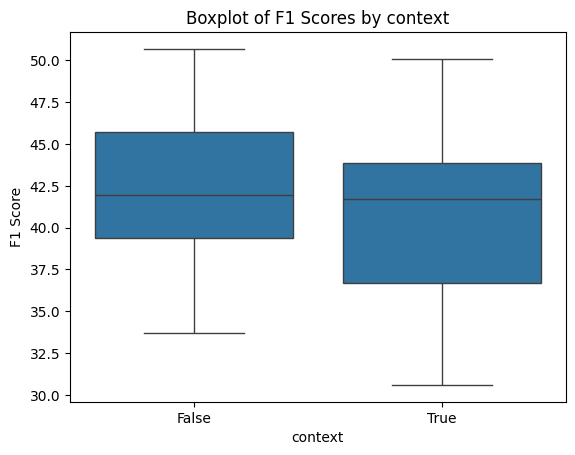

In [6]:
# Exclude models with engineered features and modified class head
exclude = ['hashtags_', 'mentions_', 'emojis_', 'VADER', 'VAD', 'POS_', 'modified_class_head', 'dropout_between_fc']
filtered_raw_metrics_df = raw_metrics_df[~raw_metrics_df['directory'].str.contains('|'.join(exclude))]

# Perform statistical tests for means of groups
group = 'context'
groups = filtered_raw_metrics_df[group].unique()
group1 = filtered_raw_metrics_df[filtered_raw_metrics_df[group] == groups[0]]['test_f1']
group2 = filtered_raw_metrics_df[filtered_raw_metrics_df[group] == groups[1]]['test_f1']
results = compare_means(group1, group2)
print("Results of statistical test for F1 scores:")
print(results['conclusion'])
print("Info on the test performed:", results)
compare_f1_scores_of_groups(filtered_raw_metrics_df, group)

## Is there a specific feature better for the model than the others

In [7]:
# Roberta-base models only without modified class head
include = ['microsoft_deberta-v3-base']
# include = ['roberta-base', 'microsoft_deberta-v3-base']
exclude = ['modified_class_head', 'dropout_between_fc']
filtered_raw_metrics_df = raw_metrics_df[raw_metrics_df['directory'].str.contains('|'.join(include)) & ~raw_metrics_df['directory'].str.contains('|'.join(exclude))]

Results of statistical test for F1 scores:
no reject, we can assume the means are equal
Info on the test performed: {'normality_pass': False, 'homoscedasticity_pass': True, 'test': 'Mann-Whitney U test', 'p_value': 0.5438299490150322, 'conclusion': 'no reject, we can assume the means are equal', 'n1': 30, 'n2': 18}
Average F1 scores:
 hashtags
False    45.642333
True     43.790000
Name: test_f1, dtype: float64


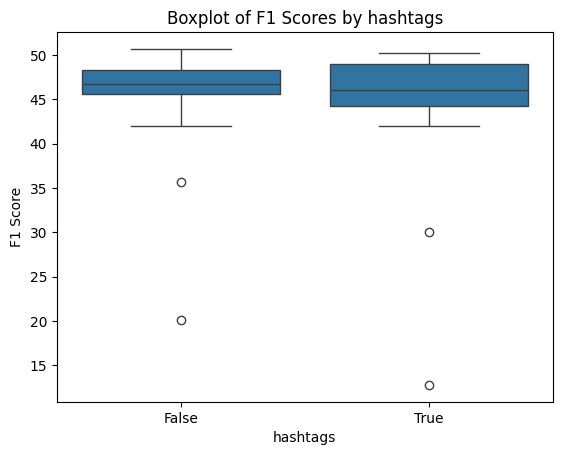

Results of statistical test for F1 scores:
no reject, we can assume the means are equal
Info on the test performed: {'normality_pass': False, 'homoscedasticity_pass': False, 'test': 'Mann-Whitney U test', 'p_value': 0.05524531853036189, 'conclusion': 'no reject, we can assume the means are equal', 'n1': 30, 'n2': 18}
Average F1 scores:
 mentions
False    46.664333
True     42.086667
Name: test_f1, dtype: float64


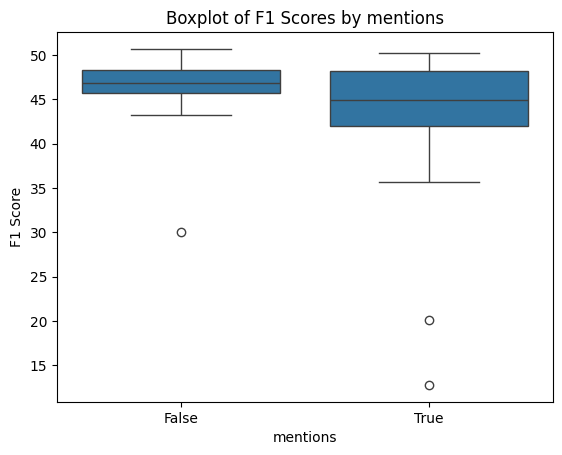

Results of statistical test for F1 scores:
no reject, we can assume the means are equal
Info on the test performed: {'normality_pass': False, 'homoscedasticity_pass': True, 'test': 'Mann-Whitney U test', 'p_value': 0.8065008987752478, 'conclusion': 'no reject, we can assume the means are equal', 'n1': 30, 'n2': 18}
Average F1 scores:
 emojis
False    44.964000
True     44.920556
Name: test_f1, dtype: float64


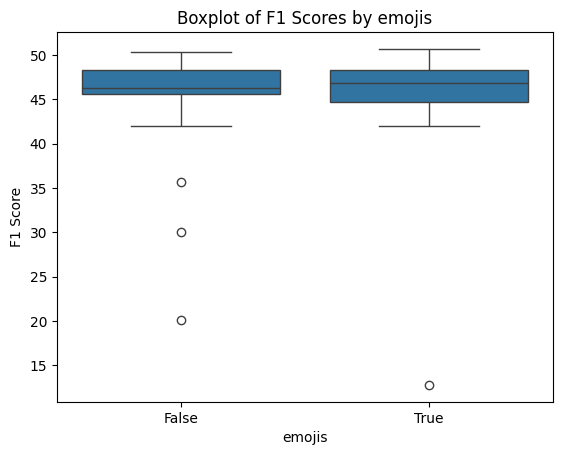

Results of statistical test for F1 scores:
no reject, we can assume the means are equal
Info on the test performed: {'normality_pass': False, 'homoscedasticity_pass': True, 'test': 'Mann-Whitney U test', 'p_value': 0.23378312641420285, 'conclusion': 'no reject, we can assume the means are equal', 'n1': 36, 'n2': 12}
Average F1 scores:
 sentiment_scores
False    44.233611
True     47.090000
Name: test_f1, dtype: float64


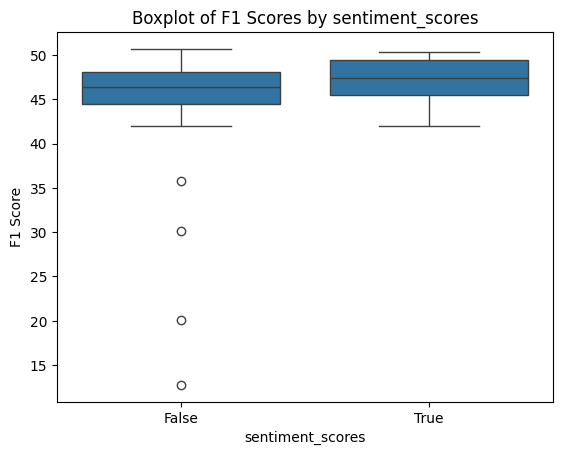

Results of statistical test for F1 scores:
no reject, we can assume the means are equal
Info on the test performed: {'normality_pass': False, 'homoscedasticity_pass': True, 'test': 'Mann-Whitney U test', 'p_value': 0.9525271802847304, 'conclusion': 'no reject, we can assume the means are equal', 'n1': 36, 'n2': 12}
Average F1 scores:
 pos
False    44.462500
True     46.403333
Name: test_f1, dtype: float64


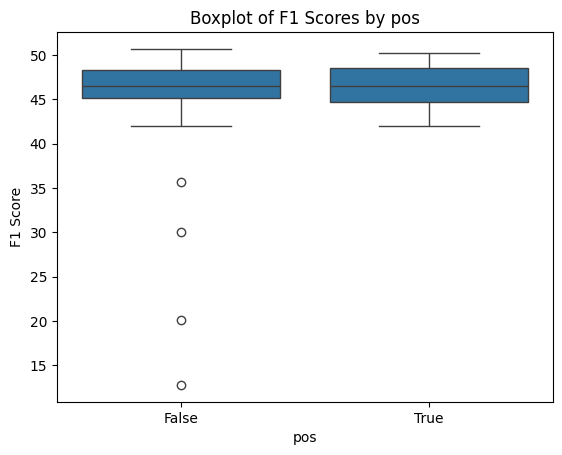

Results of statistical test for F1 scores:
no reject, we can assume the means are equal
Info on the test performed: {'normality_pass': False, 'homoscedasticity_pass': True, 'test': 'Mann-Whitney U test', 'p_value': 0.3770165467805071, 'conclusion': 'no reject, we can assume the means are equal', 'n1': 27, 'n2': 21}
Average F1 scores:
 fc_after_features
False    45.990000
True     43.607619
Name: test_f1, dtype: float64


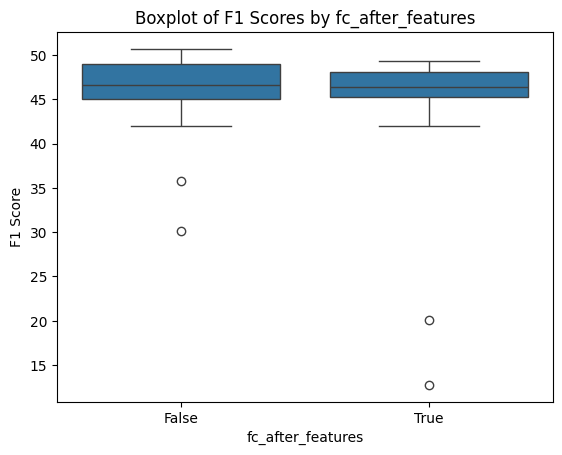

In [8]:
for group in ['hashtags', 'mentions', 'emojis', 'sentiment_scores', 'pos', 'fc_after_features']:
    # Perform statistical tests for means of groups
    groups = filtered_raw_metrics_df[group].unique()
    group1 = filtered_raw_metrics_df[filtered_raw_metrics_df[group] == groups[0]]['test_f1']
    group2 = filtered_raw_metrics_df[filtered_raw_metrics_df[group] == groups[1]]['test_f1']
    results = compare_means(group1, group2)
    print("Results of statistical test for F1 scores:")
    print(results['conclusion'])
    print("Info on the test performed:", results)
    compare_f1_scores_of_groups(filtered_raw_metrics_df, group)

## Ablation study

Only for microsoft_deberta-v3-base models

In [9]:
# Roberta-base models only without modified class head
include = ['microsoft_deberta-v3-base']
# include = ['roberta-base', 'microsoft_deberta-v3-base']
exclude = ['modified_class_head', 'dropout_between_fc', 'fc_features']
deberta_summary_metrics_df = summary_metrics_df[summary_metrics_df['directory'].str.contains('|'.join(include)) & ~summary_metrics_df['directory'].str.contains('|'.join(exclude))]
print(deberta_summary_metrics_df['directory'].to_list())
deberta_summary_metrics_df[['context', 'hashtags', 'mentions', 'emojis', 'sentiment_scores', 'pos', 'test_f1']]

['microsoft_deberta-v3-base_with_context_VADER_VAD__finetuned_50_epochs', 'microsoft_deberta-v3-base_with_context_emojis__finetuned_50_epochs', 'microsoft_deberta-v3-base_finetuned_50_epochs', 'microsoft_deberta-v3-base_with_context_hashtags_mentions_emojis_VADER_VAD_POS__finetuned_50_epochs', 'microsoft_deberta-v3-base_with_context__finetuned_50_epochs', 'microsoft_deberta-v3-base_with_context_POS__finetuned_50_epochs', 'microsoft_deberta-v3-base_with_context_hashtags_mentions_emojis__finetuned_50_epochs', 'microsoft_deberta-v3-base_with_context_mentions__finetuned_50_epochs', 'microsoft_deberta-v3-base_with_context_hashtags__finetuned_50_epochs']


,context,hashtags,mentions,emojis,sentiment_scores,pos,test_f1
18,True,False,False,False,True,False,48.77
21,True,False,False,True,False,False,48.47
14,False,False,False,False,False,False,47.80
25,True,True,True,True,True,True,47.25
19,True,False,False,False,False,False,47.20
16,True,False,False,False,False,True,46.41
27,True,True,True,True,False,False,45.51
29,True,False,True,False,False,False,41.27
23,True,True,False,False,False,False,41.24


## Performance of the best model

In [10]:
# Get best model
best_model = summary_metrics_df.iloc[0]['directory']
print('Best model:', best_model)

# Get the best run of the best model
best_run = raw_metrics_df[raw_metrics_df['directory'] == best_model].sort_values(by='test_f1', ascending=False).iloc[0]
print('Best run of the best model:', best_run['run'])

# Path to the best model run
best_model_path = os.path.join('results/models/', best_model, best_run['run'])

# Load the best model's test predictions
with open(best_model_path + '/true_labels_and_predictions.jsonl', 'r') as jsonl_file:
    true_labels_and_predictions = [json.loads(line) for line in jsonl_file]

# Convert the list of dictionaries to a pandas DataFrame
df_true_labels_and_predictions = pd.DataFrame(true_labels_and_predictions)

# Extract true labels and predictions
true_labels = df_true_labels_and_predictions['true_labels'].apply(pd.Series).values
predictions = df_true_labels_and_predictions['predictions'].apply(pd.Series).values

# List of fallacies
fallacies = ['Ad Hominem', 'Appeal to Fear', 'Appeal to Ridicule', 'False Dilemma', 'Hasty Generalization', 'Loaded Language', 'None of the above']


Best model: microsoft_deberta-v3-base_with_context_VADER_VAD__finetuned_50_epochs
Best run of the best model: run_3


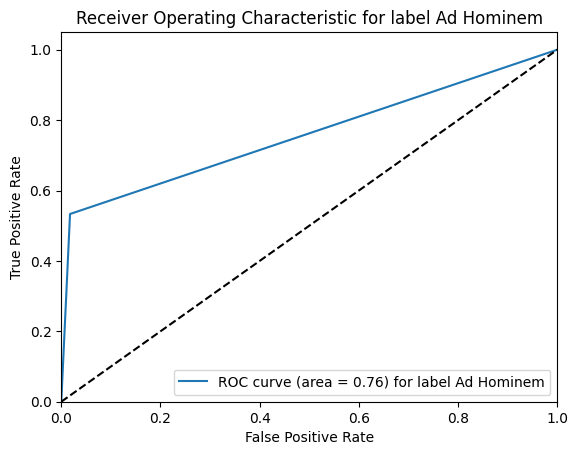

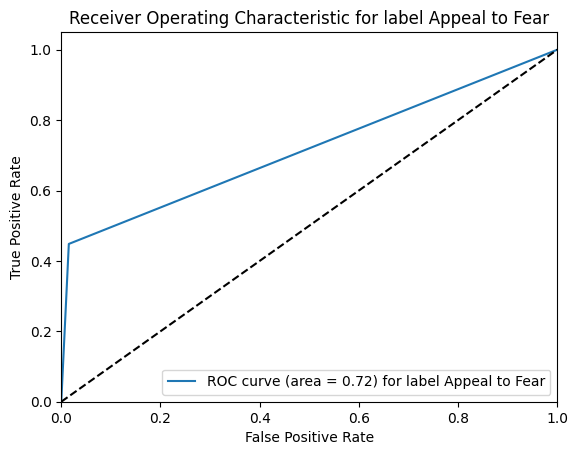

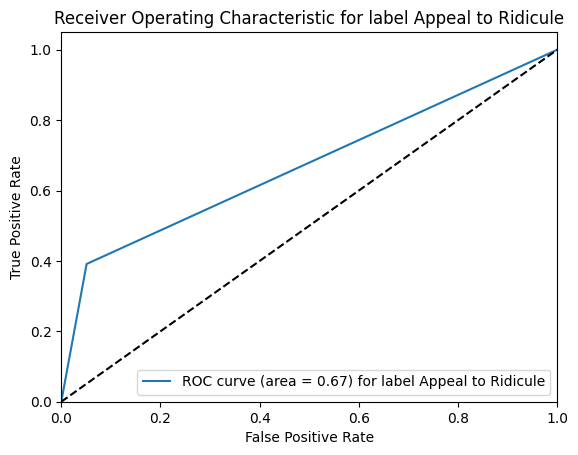

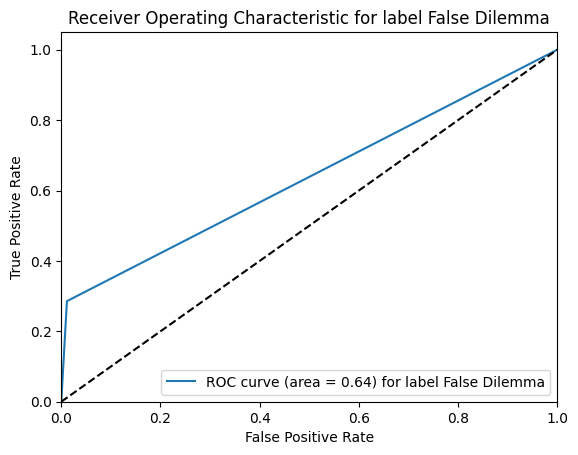

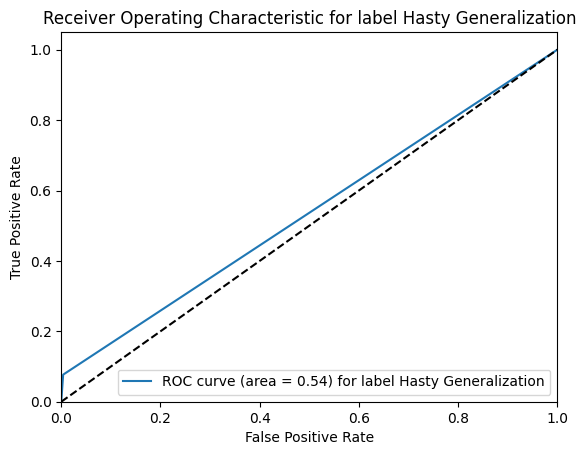

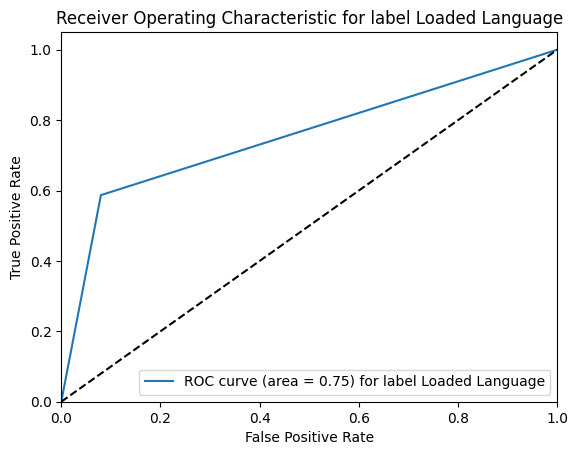

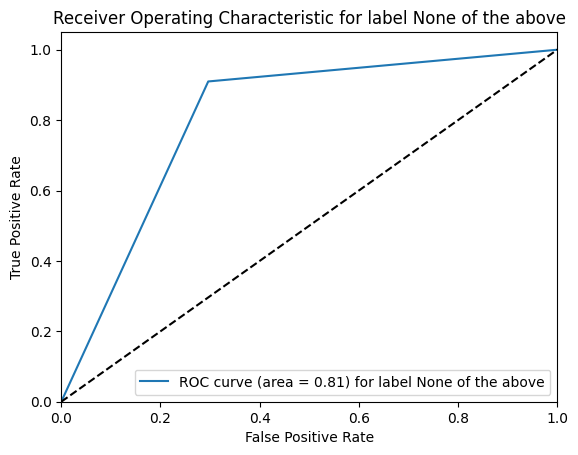

In [11]:
for i in range(true_labels.shape[1]):
    fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f}) for label {fallacies[i]}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for label {fallacies[i]}')
    plt.legend(loc="lower right")
    plt.show()

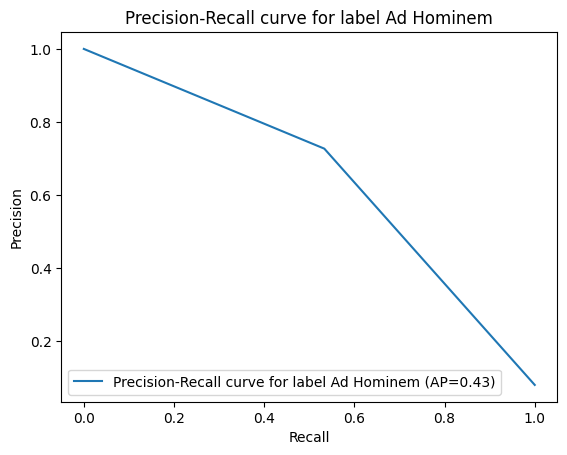

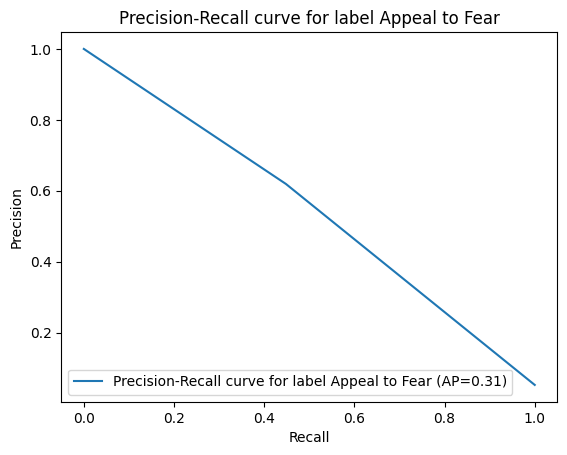

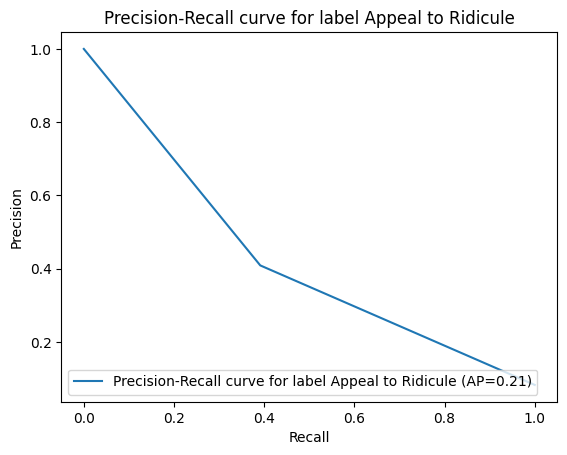

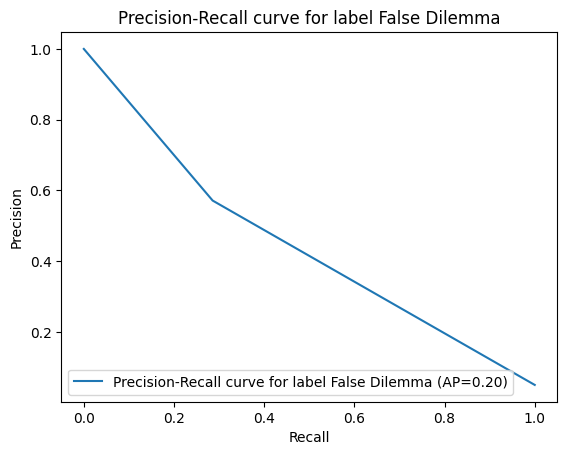

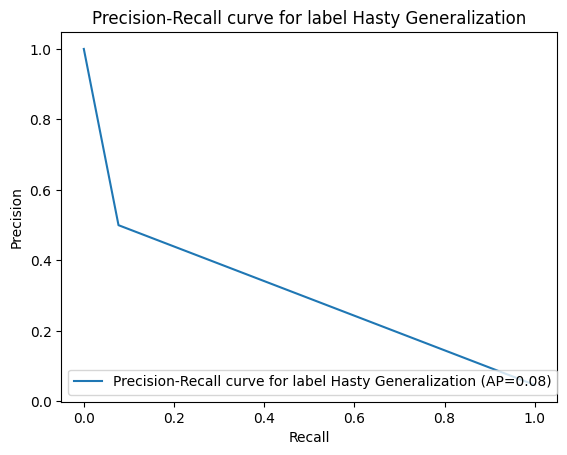

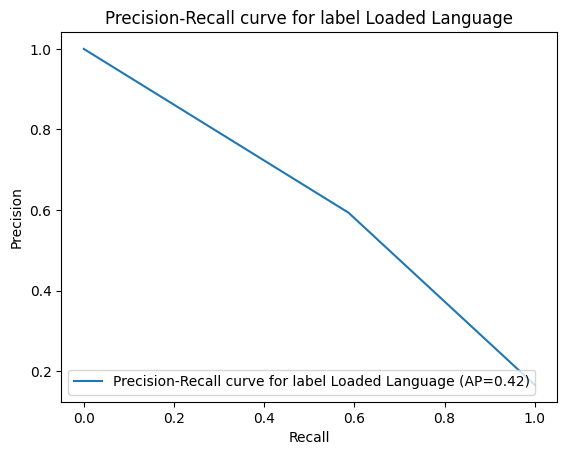

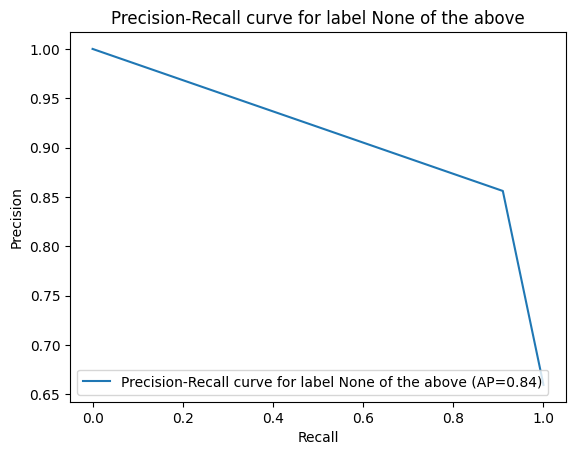

In [12]:
for i in range(true_labels.shape[1]):
    precision, recall, _ = precision_recall_curve(true_labels[:, i], predictions[:, i])
    average_precision = average_precision_score(true_labels[:, i], predictions[:, i])

    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve for label {fallacies[i]} (AP={average_precision:0.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve for label {fallacies[i]}')
    plt.legend(loc="lower left")
    plt.show()


### Classification report

"Ad Hominem," "Appeal to Fear," "Appeal to Ridicule," "False Dilemma," and "Hasty Generalization" are likely to be under-predicted. The model misses a significant number of instances of these classes, as indicated by their low recall.
Particularly, the model struggles with "Hasty Generalization."  
"Loaded Language" and "None of the Above" are predicted reasonably well. They present balanced values in precision and recall. 
The micro average and weighted average scores indicate reasonably good performance across all classes, with f1-scores around 0.74 to 0.75. However, the macro average reveals that the model’s performance is uneven across different classes, especially for those with less support.


In [15]:
print(classification_report(y_true=true_labels, y_pred=predictions, target_names=fallacies, output_dict=False, zero_division='warn'))

# Generate the classification report as a DataFrame
report_dict = classification_report(y_true=true_labels, y_pred=predictions, target_names=fallacies, output_dict=True, zero_division='warn')
df = pd.DataFrame(report_dict).transpose()

# Save to LaTeX
print(df.round(3).to_latex())
# print(df.to_latex())


                      precision    recall  f1-score   support

          Ad Hominem       0.73      0.53      0.62        45
      Appeal to Fear       0.62      0.45      0.52        29
  Appeal to Ridicule       0.41      0.39      0.40        46
       False Dilemma       0.57      0.29      0.38        28
Hasty Generalization       0.50      0.08      0.13        26
     Loaded Language       0.59      0.59      0.59        92
   None of the above       0.86      0.91      0.88       366

           micro avg       0.76      0.72      0.74       632
           macro avg       0.61      0.46      0.50       632
        weighted avg       0.74      0.72      0.72       632
         samples avg       0.76      0.75      0.75       632

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
Ad Hominem & 0.727000 & 0.533000 & 0.615000 & 45.000000 \\
Appeal to Fear & 0.619000 & 0.448000 & 0.520000 & 29.000000 \\
Appeal to Ridicule & 0.409000 & 0.391000 & 0

/user/machaves/home/Documents/twitter_fallacy_classification/project_venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/user/machaves/home/Documents/twitter_fallacy_classification/project_venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### File for error analysis

In [14]:
# Create a function to map binary vectors to text labels
def map_labels_to_text(labels):
    return [fallacies[i] for i, label in enumerate(labels) if label == 1]

# Apply the mapping function to the true labels and predictions
df_true_labels_and_predictions['true_labels_text'] = df_true_labels_and_predictions['true_labels'].apply(map_labels_to_text)
df_true_labels_and_predictions['predictions_text'] = df_true_labels_and_predictions['predictions'].apply(map_labels_to_text)

df_true_labels_and_predictions[['main_tweet','context', 'true_labels_text', 'predictions_text']].to_csv(best_model_path + 'true_labels_and_predictions.csv', index=False)
df_true_labels_and_predictions


,main_tweet,context,true_labels,predictions,true_labels_text,predictions_text
0,[user114344]: BREAKING: Florida Family Charge...,[user114344]: BREAKING: Florida Family Charge...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",[None of the above],[None of the above]
1,[user7892]: Always florida 🤦🏼♂ we can't catch...,[user114344]: BREAKING: Florida Family Charge...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]",[Hasty Generalization],"[Appeal to Ridicule, Loaded Language]"
2,[user111258]: That's definitely some Florida ...,[user114344]: BREAKING: Florida Family Charge...,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[Hasty Generalization, Loaded Language]",[Loaded Language]
3,[user127544]: What has 9 arms 12 legs 7 heads...,[user114344]: BREAKING: Florida Family Charge...,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[Ad Hominem, Appeal to Fear]",[Appeal to Ridicule]
4,[user80357]: im mad at the people who bought ...,[user114344]: BREAKING: Florida Family Charge...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",[None of the above],[None of the above]
...,...,...,...,...,...,...
550,[user25026]: As 2020 draws to a close we can ...,[user25026]: As 2020 draws to a close we can ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",[Loaded Language],[Loaded Language]
551,[user65864]: A 70yr old priest who volunteere...,[user65864]: A 70yr old priest who volunteere...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",[None of the above],[None of the above]
552,[user8624]: @user @user ... @user NO EU-Brazi...,[user8624]: @user @user ... @user NO! You don...,"[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[Appeal to Fear, False Dilemma, Loaded Language]",[]
553,[user41868]: Exclusive: Moderna vaccine trial...,[user41868]: Exclusive: Moderna vaccine trial...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",[None of the above],[None of the above]
